In [1]:
library(ggplot2)
library(dplyr)
library(reshape2)
library(binom)
library(tidyverse)
library(ggbreak)
library(ggVennDiagram)
library(ggvenn)
library(patchwork)
library(scales)
library(data.table)
library(ggpubr)
library(arrow)
library(readxl)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.1     ✔ tidyr     1.3.0
✔ readr     2.1.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
ggbreak v0.1.2

If you use ggbreak in published research, please cite the following
paper:

S Xu, M Chen, T Feng, L Zhan, L Zhou, G Yu. Use ggbreak to effectively
utilize plotting space to deal with large datasets and outliers.
Frontiers in Genetics. 2021, 12:774846. doi: 10.3389/fgene.2021.774846


Loading requir

In [2]:
pl_theme = theme(plot.title = element_text(size = 10, face = "bold"), 
          axis.text=element_text(size=6),
          axis.title=element_text(size=8),
          legend.text = element_text(size=6),
          legend.title = element_text(size=7),
          strip.text = element_text(size=6),
          axis.ticks = element_line(colour = "black", linewidth = 0.4),
          legend.key.size = unit(4, 'mm'),
          text = element_text(family='Arial')
         )
pl_theme_half_page = theme(plot.title = element_text(size = 6, face = "bold"), 
          axis.text=element_text(size=5),
          axis.title=element_text(size=6),
          legend.text = element_text(size=3),
          legend.title = element_text(size=4.5),
          strip.text = element_text(size=5),
          axis.ticks = element_line(colour = "black", linewidth = 0.2),
          legend.key.size = unit(2, 'mm'),
          text = element_text(family='Arial')
         )
simple_annot_names = c('non-genic', 'putative regulatory', 'coding')

In [3]:
annot_colors <- c(
    "LoF" = "#DE3F2E",
    "missense" = "#FDD384",
    "synonymous" = "#E5E5AB",
    "UTR3" = "#807DBA",
    "UTR5" = "#BCBDDC",
    "promoter" = "#08519C",
    "CRE" = "#4292C6",
    "conserved" = "grey",
    "non-genic" = "#C6DBEF"
)
simple_annot_colors <- c(
    "coding" = "#FDD384",
    "putative regulatory" = "#08519C",
    "non-genic" = "#C6DBEF"
)
method_colors <- c(
    "SuSiE" = "#4169e1",
    "SuSiE-inf" = "#91dce3",
    "FINEMAP" = "#FFA500",
    "FINEMAP-inf" = "#673147",
    "ABF" = "#32CD32",
    "COJO-ABF" = "#cb98fb",
    "minPIP" = "#708090",
    "minPIP-inf" = "#ffb6c1")

pheno_colors <- c(
    "LDLC" = '#083647',
    "ALP" = '#5E4FA2',
    "HbA1c" = '#3F96B7',
    "Lym" = '#88CFA4',
    "Plt" = '#D7EF9B',
    "RBC" = 'yellow',
    "eGFR" = '#FDD380',
    "IGF1" = '#F88D51',
    "eBMD" = '#DC494C',
    "Height" = '#9E0142'
)
method_shapes <- c(
    "SuSiE" = 8,
    "SuSiE-inf" = 19,
    "FINEMAP" = 7,
    "FINEMAP-inf" = 15,
    "minPIP" = 9,
    "minPIP-inf" = 17
)

sim_colors <- c(
    "Ideal" = "#a0ddff",
    "Baseline misspecification" = "#758ecd",
    "Moderate stratification w/ BOLT" = "#ec9192",
    "Moderate non-sparsity" = "#729ea1",
    "High non-sparsity" = "#b5bd89",
    "Very high non-sparsity" = "#dfbe99",
    "No large effects" = "#ebbb5c",
    "Severe stratification w/ BOLT"="#8CBFAF",
    "Moderate stratification w/ OLS"="#023778",
    "Severe stratification w/ OLS"="#4281A4",
    "1% coverage, ratio=3:1"= "#b5bd89",
    "0.5% coverage, ratio=3:1"='#4FC47E',
    "5% coverage, ratio=3:1"='#D05B5B',
    "5% coverage, ratio=15:1"='#F2CD5D'
)

In [79]:
path_pref = ''

# Extended data fig. 1 RFR at different PIP thresholds

In [5]:
rfr_diff_thresh = read_excel("Supplementary Tables.xlsx", sheet = 14)

rfr_diff_thresh$method_name = factor(rfr_diff_thresh$method_name, levels=c('ABF','COJO-ABF','SuSiE','FINEMAP',
                                                                     'SuSiE-inf','FINEMAP-inf'))
rfr_diff_thresh$segment_legend='EPN'
rfr_diff_thresh$std = sqrt((rfr_diff_thresh$rfr)*(rfr_diff_thresh$n_highpip)*(1-rfr_diff_thresh$rfr))/rfr_diff_thresh$n_highpip
selected_thresh = c(0.9,0.93,0.95,0.99)
rfr_diff_thresh <- rfr_diff_thresh %>% filter(threshold %in% selected_thresh) %>%
    filter(trait=='agg')
rfr_diff_thresh$threshold = as.factor(rfr_diff_thresh$threshold)

pos_dodge = 1
num_methods = length(unique(rfr_diff_thresh$method_name))
barwidth = 0.85/num_methods

xstart = seq(1-barwidth*num_methods/2,1+barwidth*num_methods/2-barwidth,length.out=num_methods)
xend = seq(1-barwidth*num_methods/2+barwidth,1+barwidth*num_methods/2,length.out=num_methods)
for (i in 1:3){
    new_vec = seq(1-barwidth*num_methods/2+ i*pos_dodge, 
                  1+barwidth*num_methods/2-barwidth+ i*pos_dodge, 
                  length.out=num_methods)
    xstart <- c(xstart, new_vec)
    new_vec = seq(1-barwidth*num_methods/2+barwidth+i*pos_dodge,
                  1+barwidth*num_methods/2+i*pos_dodge,
                  length.out=num_methods)
    xend <- c(xend, new_vec)
}

pl_rfr_diff_thresh = ggplot(data=rfr_diff_thresh, 
       aes(x=threshold, y=rfr, fill=method_name)) +
    geom_bar(position=position_dodge(), color='black', stat="identity",width=0.85, linewidth=0.15) + 
    geom_segment(data=rfr_diff_thresh %>% filter(data_type=='Real data'), aes(x=xstart, y=epn, 
                 xend=xend, yend=epn, 
                 color=method_name,linetype=`segment_legend`), 
                 size=0.3,color='black',inherit.aes = FALSE)+
    geom_segment(data=rfr_diff_thresh %>% filter(data_type=='Ideal simulation'), aes(x=xstart, y=epn, 
                 xend=xend, yend=epn, 
                 color=method_name,linetype=`segment_legend`), 
                 size=0.3,color='black',inherit.aes = FALSE)+
    geom_errorbar(aes(ymin=rfr-std, ymax=rfr+std),position=position_dodge(.85),width=0.2,linewidth=0.2)+
    facet_wrap(~data_type)+
    ylab(label = "Replication failure rate")+
    xlab(label = 'PIP threshold')+
    scale_linetype_manual("EPN",values=c("EPN"=1))+
    scale_fill_manual(values=method_colors[unique(rfr_diff_thresh$method_name)])+
    pl_theme + theme(legend.title = element_blank())


New names:
• `` -> `...1`
Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


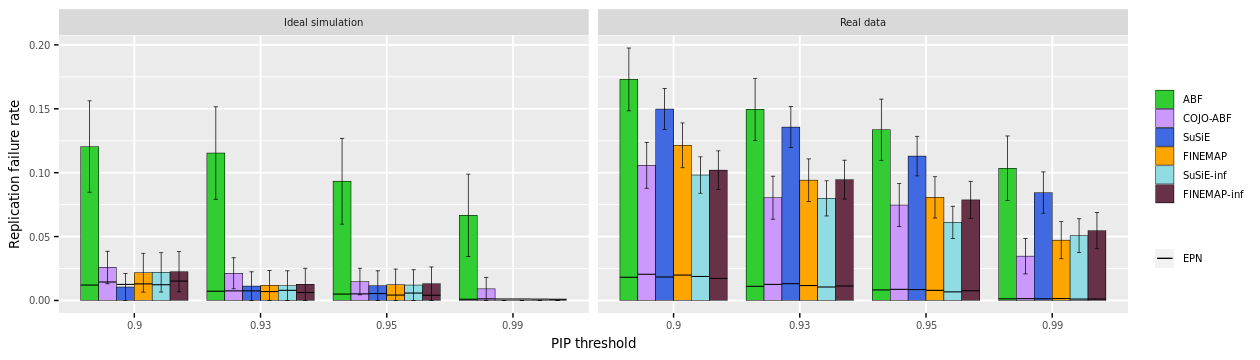

In [6]:
options(repr.plot.width=10.5, repr.plot.height=3)
pl_rfr_diff_thresh

In [26]:
cowplot::save_plot(
  paste0(path_pref,"/ExtFig1_RFR_diff_thresholds.jpg"),
  pl_rfr_diff_thresh,
  base_height = 60,
  base_width = 180,
  device = jpeg,
  units = 'mm',
  dpi=600
)

# Extended Data Fig. 2 Calibration for different non-sparsity coverage

In [7]:
calib_df = read_excel('Supplementary Tables.xlsx', sheet=15)
selected_sims = c('1% coverage, ratio=3:1',
                  "0.5% coverage, ratio=3:1",
                  "5% coverage, ratio=3:1",
                  "5% coverage, ratio=15:1")
selected_methods = c('SuSiE', 'SuSiE-inf', 'FINEMAP', 'FINEMAP-inf')
calib_to_plot <- calib_df %>% filter(sim_name %in% selected_sims)
calib_to_plot$sim_name = factor(calib_to_plot$sim_name, selected_sims)
calib_to_plot$method_name = factor(calib_to_plot$method_name, selected_methods)
calib_to_plot$bin_name <- factor(calib_to_plot$bin_name, 
                                 levels=c('[0,0.01]','(0.1,0.5]','(0.5,0.9]','(0.9,1]'))

New names:
• `` -> `...1`


In [8]:
pl_calib <- ggplot(calib_to_plot, aes(bin_name, prop_causal)) +
    geom_pointrange(
        aes(ymin = lower, ymax = upper, color=sim_name, shape=method_name,
            group=interaction(method_category, sim_name),),
        position = position_dodge(1),
        size=0.4, linewidth=0.1, stroke=0.25)+
    geom_point(aes(bin_name, mean_pip, shape=EPC,
                   group=interaction(method_category, sim_name)), position=position_dodge(1),
               color="Black", size=2, stroke=0.5, shape=95) +
    ylab('Proportion causal')+
    xlab("PIP bins") + pl_theme + 
    theme(strip.background = element_blank(),
          strip.text.y = element_blank(),
          panel.background = element_rect(fill = 'white', color = 'grey'))+
    scale_shape_manual(values=c(method_shapes)) +
    scale_color_manual(values=sim_colors[selected_sims]) +
    scale_fill_manual(values=sim_colors[selected_sims]) +
    guides(color=guide_legend(title="Simulation type"),
           fill=guide_legend(title="Simulation type"),
           shape=guide_legend(title="Method"),
           group=guide_legend(title=" "))

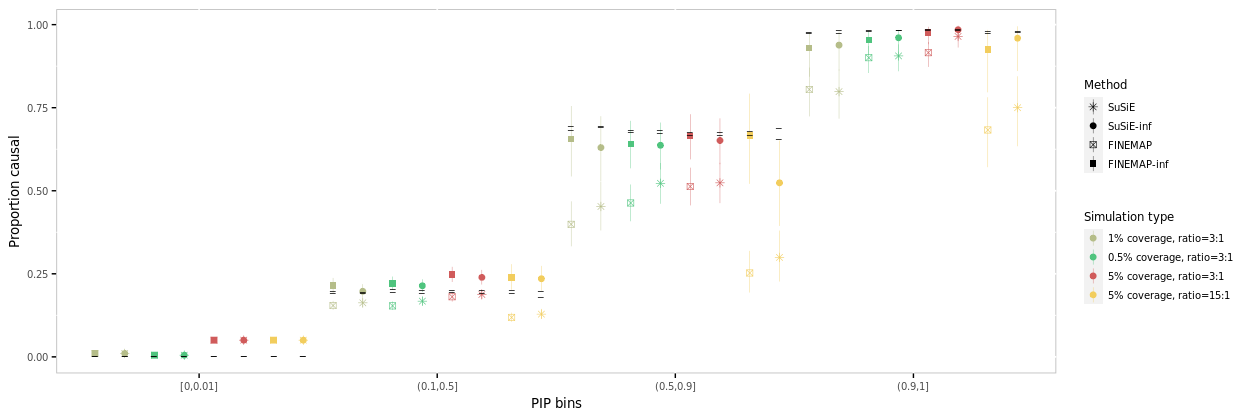

In [9]:
options(repr.plot.width=10.5, repr.plot.height=3.5)
pl_calib

In [13]:
cowplot::save_plot(
  paste0(path_pref, "ExtFig2_calib_diff_coverage.jpg"),
  pl_calib,
  base_height = 60,
  base_width = 180,
  device = jpeg,
  units = 'mm',
  dpi=600
)

# Extended Data Fig. 3 Additional real data improvements

In [10]:
# Top N SNPs enrichment plot
top_n = read_excel("Supplementary Tables.xlsx", sheet = 16)
selected_methods = c('SuSiE','SuSiE-inf','FINEMAP','FINEMAP-inf') 
top_n = (top_n %>% filter(method_name %in% selected_methods) %>% mutate(coding=(LoF + missense))
                            %>% mutate('putative regulatory'=(synonymous+UTR3+UTR5+promoter+CRE+conserved))
                            %>% dplyr::select(top_N, method_name, coding, 'putative regulatory', 'non-genic'))
melted_data <-  reshape2::melt(top_n , id.vars = c("top_N","method_name"), measure.vars = simple_annot_names)
data <- melted_data %>% group_by(top_N,method_name)
data <- mutate(data, prop = value / sum(value), 
               std = sqrt(sum(value)*(value/sum(value))*(1-(value/sum(value))))/sum(value),
               sd_pos = cumsum(prop))
data$method_name<-factor(data$method_name, levels= selected_methods)
data$variable <- factor(data$variable,levels=simple_annot_names)
pl_top_n <- qplot(x = method_name, y = prop, fill = variable, data = data, geom = "col") +
    geom_errorbar(aes(x=method_name,ymin=1-prop+std,ymax=1-prop-std),width=.1, linewidth=0.3, 
                  data=data %>% filter(variable=='non-genic'),
                  inherit.aes = FALSE)+
    facet_wrap(~top_N)+
    ggtitle('Top N variants (BOLT)')+
    scale_fill_manual(values = simple_annot_colors) +
    scale_y_continuous(label=c(0,0.25,0.5,0.75,1)) +
    pl_theme + coord_flip() + theme(axis.title=element_blank(),
                                    legend.title=element_blank(),
                                    legend.position='none')

New names:
• `` -> `...1`
Warning message:
“`qplot()` was deprecated in ggplot2 3.4.0.”


In [11]:
# Top N SNPs enrichment plot
top_n = read_excel('Supplementary Tables.xlsx', sheet=17)
selected_methods = c('SuSiE','SuSiE-inf','FINEMAP','FINEMAP-inf') 
top_n = (top_n %>% filter(method_name %in% selected_methods) %>% mutate(coding=(LoF + missense))
                            %>% mutate('putative regulatory'=(synonymous+UTR3+UTR5+promoter+CRE+conserved))
                            %>% dplyr::select(top_N, method_name, coding, 'putative regulatory', 'non-genic'))
melted_data <-  reshape2::melt(top_n , id.vars = c("top_N","method_name"), measure.vars = simple_annot_names)
data <- melted_data %>% group_by(top_N,method_name)
data <- mutate(data, prop = value / sum(value), 
               std = sqrt(sum(value)*(value/sum(value))*(1-(value/sum(value))))/sum(value),
               sd_pos = cumsum(prop))
data$method_name<-factor(data$method_name, levels= selected_methods)
data$variable <- factor(data$variable,levels=simple_annot_names)
pl_top_n_ols <- qplot(x = method_name, y = prop, fill = variable, data = data, geom = "col") +
    geom_errorbar(aes(x=method_name,ymin=1-prop+std,ymax=1-prop-std),width=.1, linewidth=0.3, 
              data=data %>% filter(variable=='non-genic'),
              inherit.aes = FALSE)+
    facet_wrap(~top_N)+
    scale_y_continuous(label=c(0,0.25,0.5,0.75,1)) +
    ggtitle('Top N variants (OLS)')+
    scale_fill_manual(values = simple_annot_colors) +
    pl_theme + coord_flip() + theme(axis.title=element_blank(), 
                                    legend.title=element_blank(),
                                    legend.position='none')

New names:
• `` -> `...1`


In [12]:
# OLS set difference functional enrichment
set_diff_enrich = read_excel('Supplementary Tables.xlsx', sheet=18)
set_diff_enrich$type_name = c('High-PIP for SuSiE \n and not SuSiE-inf',
                              'High-PIP for SuSiE-inf \n and not SuSiE',
                              'High-PIP for FINEMAP \n and not FINEMAP-inf',
                              'High-PIP for FINEMAP-inf \n and not FINEMAP')
selected = c('High-PIP for SuSiE \n and not SuSiE-inf',
                              'High-PIP for SuSiE-inf \n and not SuSiE',
                              'High-PIP for FINEMAP \n and not FINEMAP-inf',
                              'High-PIP for FINEMAP-inf \n and not FINEMAP')
set_diff_enrich <- (set_diff_enrich %>% mutate(coding=(LoF + missense))
                            %>% mutate('putative regulatory'=(synonymous+UTR3+UTR5+promoter+CRE+conserved))
                            %>% dplyr::select(type_name,coding, 'putative regulatory', 'non-genic', 'num_snps'))
set_diff_enrich = set_diff_enrich %>% filter(type_name %in% selected)
set_diff_enrich$type_name <-factor(set_diff_enrich$type_name, levels= c('High-PIP for SuSiE \n and not SuSiE-inf',
                              'High-PIP for SuSiE-inf \n and not SuSiE',
                              'High-PIP for FINEMAP \n and not FINEMAP-inf',
                              'High-PIP for FINEMAP-inf \n and not FINEMAP'))
melted_data <-  reshape2::melt(set_diff_enrich, id.vars = c("type_name"), measure.vars = simple_annot_names)
data <- group_by(melted_data,type_name)
data <- mutate(data, prop = value / sum(value), 
               std = sqrt(sum(value)*(value/sum(value))*(1-(value/sum(value))))/sum(value),
               sd_pos = cumsum(prop))
data$type_name<-factor(data$type_name, levels= selected)
data$variable <- factor(data$variable,levels=simple_annot_names)

pl_set_diff_enrich_ols <- qplot(x = type_name, y = prop, fill = variable, data = data, geom = "col") +
    geom_errorbar(aes(x=type_name,ymin=1-prop+std,ymax=1-prop-std),width=.1, linewidth=0.3, 
                  data=data %>% filter(variable=='non-genic'),
                  inherit.aes = FALSE)+
    ggtitle('High-PIP set diff (OLS)')+
    pl_theme + theme(plot.title = element_text(hjust=0.4),
                    axis.title=element_blank(), legend.title=element_blank(), 
                     legend.position="none") +
    scale_y_continuous(label=c(0,0.25,0.5,0.75,1)) +
    scale_fill_manual(values = simple_annot_colors ) + coord_flip()

for (i in seq(1,length(selected),1)){
    #num_highpip = 
    pl_set_diff_enrich_ols = pl_set_diff_enrich_ols + annotate('text', x = i, y = 0.95, 
                                                     label = toString(set_diff_enrich$num_snps[i]))
}

New names:
• `` -> `...1`


In [13]:
df = read_excel("Supplementary Tables.xlsx", sheet = 19)
df$Type = c('a','a','b','b','c','d')
data = df %>% 
   group_by(Type) %>% 
   summarise_at(c('num_highpip_366k','num_highpip_100k','num_rep'), sum) %>% 
   mutate(method_name = c('SuSiE&FINEMAP','SuSiE-inf&FINEMAP-inf','minPIP','minPIP-inf')) %>%
   select(c('num_highpip_366k','num_highpip_100k','num_rep','method_name')) %>%
   rename(num_highpip_366k_either = num_highpip_366k,
          num_highpip_100k_either = num_highpip_100k)

data_part_1 = data %>% filter(method_name %in% c('SuSiE&FINEMAP','SuSiE-inf&FINEMAP-inf'))
data_part_2 = data %>% filter(method_name %in% c('minPIP','minPIP-inf'))
data_to_plot = data_part_1 %>% mutate(num_highpip_366k_both = data_part_2$num_highpip_366k_either,
                       num_highpip_100k_both = data_part_2$num_highpip_100k_either) %>%
                        select(num_highpip_366k_either, num_highpip_100k_either, num_rep,
                               num_highpip_366k_both, num_highpip_100k_both)

data_to_plot <- data_to_plot[2, -1] / data_to_plot[1, -1]
data_to_plot$id = 'A'
selected = c('num_highpip_100k_either','num_rep','num_highpip_100k_both')
data_to_plot <- data_to_plot %>% reshape2::melt(id.vars='id') %>% 
    filter(variable %in% selected)
data_to_plot$variable = factor(data_to_plot$variable, levels=selected)

data_to_plot$reduction = 1-data_to_plot$value

pl_reduction <- ggplot(data=data_to_plot, 
       aes(x=variable, y=reduction, fill=variable)) +
    geom_bar(color='black', stat="identity",width=0.85, size=0.35, show.legend = FALSE) +
    ylab('Proportion of reduction') +
    pl_theme +
    theme(axis.title.x = element_blank(),
          axis.text.x = element_text(angle = 90)) +
    scale_x_discrete(labels=c("num_highpip_100k_either"="High-PIP",
                              "num_rep" = "Replicated",
                              "num_highpip_100k_both" = "Shared\n high-PIP"))

New names:
• `` -> `...1`


In [14]:
cs_size_df = read_excel("Supplementary Tables.xlsx", sheet = 20)
pl_cs_size <- ggplot(cs_size_df, aes(x=method, y=num_snps_in_cs, fill=method)) + 
  geom_boxplot(linewidth=0.35)+
  scale_fill_manual(values=method_colors[c('SuSiE','SuSiE-inf')])+
  scale_y_break(c(32,300),scales = 0.5)+
  ylab('Credible set size') +
  pl_theme + theme(axis.title.x = element_blank(),
                   legend.position='none')

New names:
• `` -> `...1`


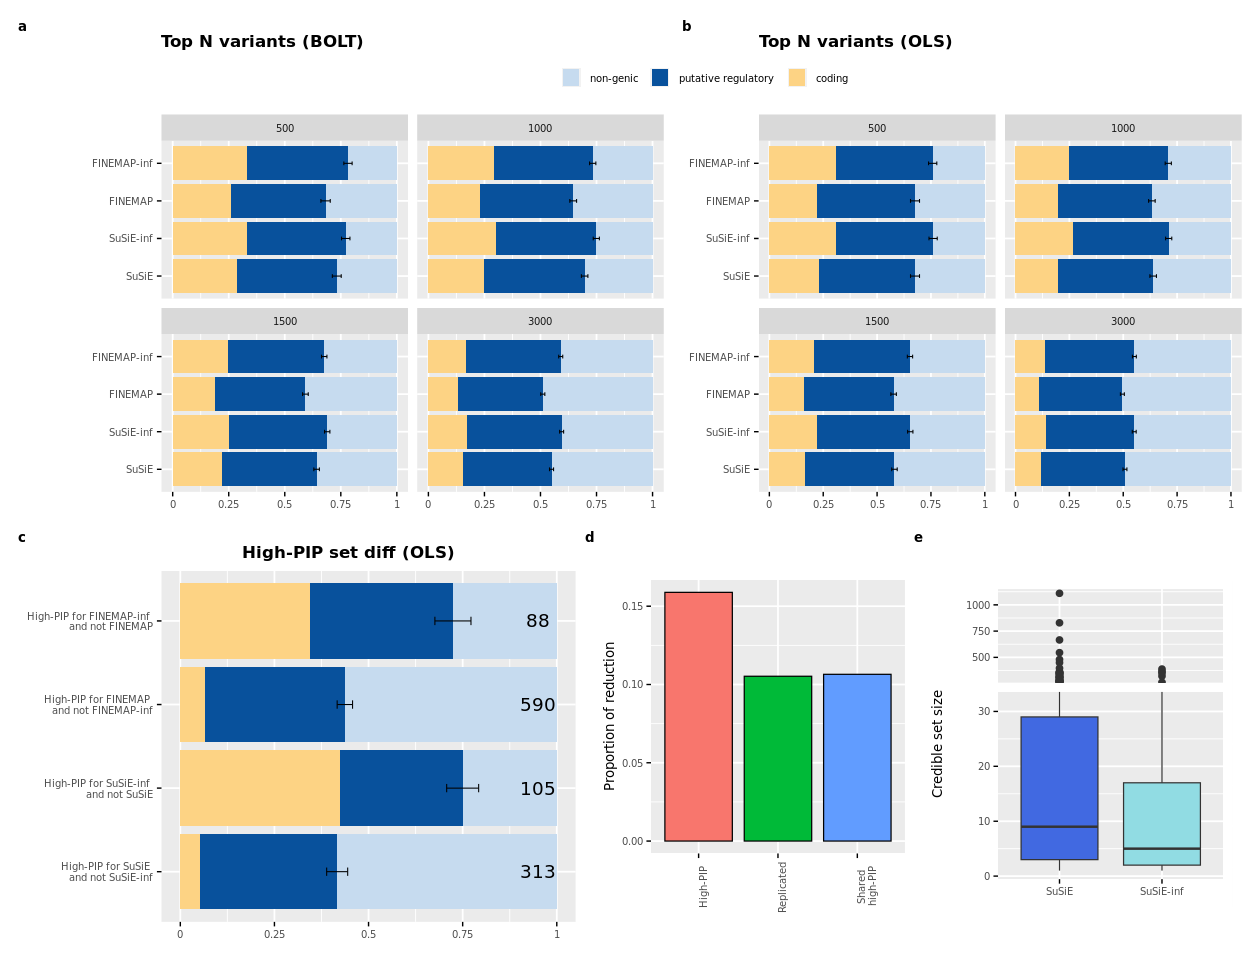

In [15]:
options(repr.plot.width=10.5, repr.plot.height=8)
layout <- "
AAAAAAABBBBBBB
CCCCCCDDDDDDDD
"
pl_top_n_both = pl_top_n + pl_top_n_ols + plot_layout(ncol=2, guides="collect")

#pl_ols = pl_top_n_ols + pl_set_diff_enrich_ols + plot_layout(ncol = 2, guides = "collect")
pl_reduction_cs = pl_reduction + pl_cs_size + plot_layout(ncol=2)
ext_fig3 <- pl_top_n_both + pl_set_diff_enrich_ols + pl_reduction_cs + plot_layout(design = layout, guides='collect')+
 plot_annotation(tag_levels = "a") & theme(plot.tag = element_text(face = 'bold', size=8),
                                           legend.position='top')
ext_fig3

In [255]:
cowplot::save_plot(
  paste0(path_pref, "/ExtFig3_additional_real_data_improvements.jpg"),
  ext_fig3,
  base_height = 140,
  base_width = 180,
  device = jpeg,
  units = 'mm',
  dpi=600
)

# Extended Data Fig. 4 Tausq estimates

In [16]:
tausq = read_excel('Supplementary Tables.xlsx', sheet=21)
tausq_to_plot = tausq %>% group_by(sim_name) %>% 
    summarise(mean = mean(susie_inf_tausq), sd = sd(susie_inf_tausq)) %>%
    mutate(lower = mean-sd, upper = mean+sd)
selected_sims = c("Baseline misspecification", 
        "Moderate non-sparsity", 
        "High non-sparsity", 
        "Very high non-sparsity", 
        "No large effects")
tausq_to_plot$sim_name = factor(tausq_to_plot$sim_name, levels=selected_sims)
pl_sim_tausq = ggplot(tausq_to_plot, aes(sim_name, mean)) +
    geom_pointrange(
        aes(ymin = lower, ymax =upper, color = sim_name),
        position = position_dodge(1),
        size=0.4, linewidth=0.45, stroke=0.25)+
    ylab('Estimated tau squared')+ pl_theme +
    scale_color_manual(values=sim_colors[selected_sims]) +
    scale_x_discrete(labels=c("Baseline misspecification" = "Baseline\n misspecification",
                              "Moderate non-sparsity" = "Moderate\n non-sparsity",
                              "High non-sparsity" = "High\n non-sparsity",
                              "Very high non-sparsity" = "Very high\n non-sparsity")) +
    theme(axis.title.x = element_blank(),
          legend.title = element_blank(),
          legend.position='none')

New names:
• `` -> `...1`


In [72]:
inf_model_tausq = as.data.frame(read_excel('Supplementary Tables.xlsx', sheet=22))
inf_model_tausq = inf_model_tausq[,-1]
inf_model_long_format = melt(inf_model_tausq, id=c("sim","sim_name","chromosome"))
inf_model_long_format = inf_model_long_format %>% 
    mutate(tausq_cat = recode(variable, 
                              'estimated_tausq_ols'='OLS',
                              'estimated_tausq_bolt'='BOLT',
                              'true_tausq'='truth')) %>%
    mutate(tausq_cat = factor(tausq_cat, levels=c('OLS','BOLT','truth'))) %>%
    group_by(sim_name, tausq_cat) %>%
    mutate(value.show = as.numeric(
    between(value, 
            quantile(value)[2] - 1.5*IQR(value),
            quantile(value)[4] + 1.5*IQR(value)))) 
inf_model_long_format_no_outlier = inf_model_long_format %>% filter(value.show==TRUE)

New names:
• `` -> `...1`
Warning message in melt(inf_model_tausq, id = c("sim", "sim_name", "chromosome")):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(inf_model_tausq). In the next version, this warning will become an error.”


In [73]:
pl_inf_model_tausq <- ggplot(inf_model_long_format_no_outlier, aes(x=sim_name, y=value, fill=tausq_cat)) +
    geom_boxplot(linewidth=0.35) +
    pl_theme +
    ylab('Estimated tau squared') +
    theme(axis.title.x=element_blank(),
          legend.title=element_blank(),
          axis.text.x = element_text(angle=90))

In [74]:
# stratification sims
strat_sims = read_excel('Supplementary Tables.xlsx', sheet=23)
strat_sims_to_plot = strat_sims %>% group_by(sim_name) %>%
    mutate(value.show = as.numeric(
    between(susie_inf_tausq, 
            quantile(susie_inf_tausq)[2] - 1.5*IQR(susie_inf_tausq),
            quantile(susie_inf_tausq)[4] + 1.5*IQR(susie_inf_tausq)))) %>%
    mutate(sim_name_unified = recode(sim_name, 'BOLT, PCx5'="Moderate stratification\n w/ BOLT",
                                     'BOLT, PCx8'="Severe stratification\n w/ BOLT",
                                     'OLS, PCx1'="Moderate stratification\n w/ OLS",
                                     'OLS, PCx2'="Severe stratification\n w/ OLS"))
strat_sims_to_plot_no_outlier = strat_sims_to_plot %>% filter(value.show==TRUE)
selected_sims = c("Moderate stratification\n w/ BOLT",
                  "Severe stratification\n w/ BOLT",
                  "Moderate stratification\n w/ OLS",
                  "Severe stratification\n w/ OLS")
strat_sims_to_plot_no_outlier$sim_name_unified = factor(strat_sims_to_plot_no_outlier$sim_name_unified,
                                                        levels=selected_sims)
pl_strat_tausq = ggplot(strat_sims_to_plot_no_outlier, aes(x=sim_name_unified, y=susie_inf_tausq)) +
    geom_boxplot(linewidth=0.35) +
    ylab('Estimated tau squared')+ pl_theme +
    theme(axis.title.x = element_blank(),
          legend.title = element_blank(),
          legend.position='none',
          axis.text.x = element_text(angle=90))

New names:
• `` -> `...1`


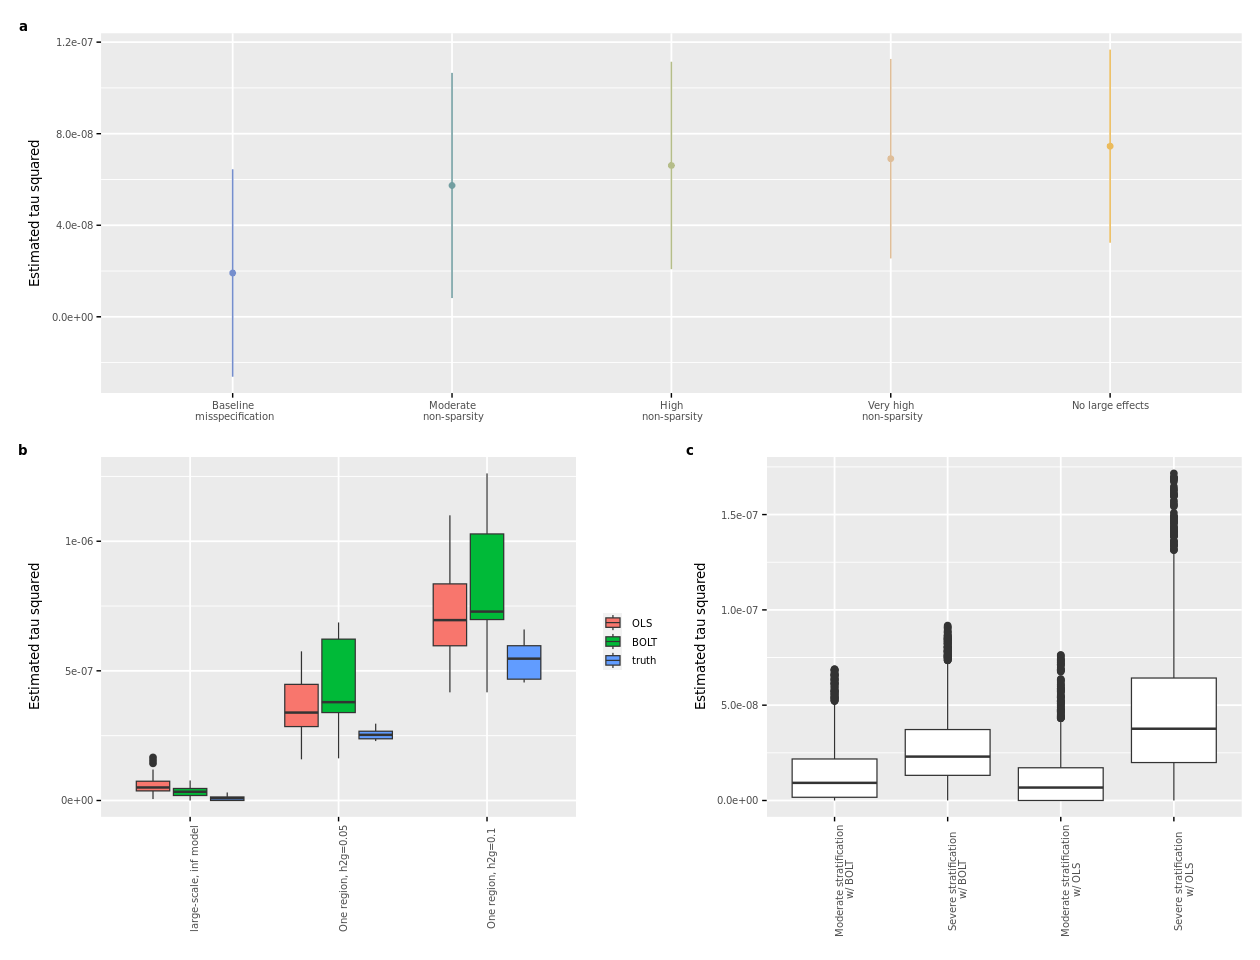

In [75]:
options(repr.plot.width=10.5, repr.plot.height=8)
layout <- "
AA
BC
"
pl_tausq <- pl_sim_tausq + pl_inf_model_tausq + pl_strat_tausq + plot_layout(design = layout)+
 plot_annotation(tag_levels = "a") & theme(plot.tag = element_text(face = 'bold', size=8))
pl_tausq

In [303]:
cowplot::save_plot(
  paste0(path_pref, "/ExtFig4_tausq_in_sims.jpg"),
  pl_tausq,
  base_height = 140,
  base_width = 180,
  device = jpeg,
  units = 'mm',
  dpi=600
)

# Extended Data Fig. 5 -- estimated tau-squared in real data

In [77]:
tausq = read_excel("Supplementary Tables.xlsx", sheet = 24)
ttest = read_excel("Supplementary Tables.xlsx", sheet = 25)
cs_tausq = read_excel("Supplementary Tables.xlsx", sheet = 26)
# box plots of tausq for 10 traits
pl_trait_tausq <- ggplot(tausq, aes(x=forcats::fct_reorder(trait, tausq, median), y=tausq, fill=trait)) +
  geom_boxplot(linewidth=0.35, show.legend = FALSE) + 
  stat_summary(fun=mean, geom="point", shape=20, size=1, color="red", fill="red") +
  ylab("Tau-squared")+
  pl_theme + theme(axis.title.x=element_blank()) +
  scale_fill_manual(values=pheno_colors[unique(tausq$trait)])
# heatmap for pair-wise t-tests
trait_order = (tausq %>% group_by(trait) %>% summarize(median_tausq = median(tausq)) %>% arrange(desc(median_tausq)))$trait
ttest$mlog10p = -log10(ttest$pvalue)
ttest$trait1 = factor(ttest$trait1, levels = trait_order)
ttest$trait2 = factor(ttest$trait2, levels = trait_order)
ttest$sig_star = cut(ttest$pvalue, breaks=c(-Inf, 0.05/90, Inf), label=c("*", ""))
pl_heatmap <- ggplot(ttest, aes(x = trait1, y = trait2, fill = mlog10p)) +
  geom_tile(color = "black") +
  geom_text(aes(label=sig_star), color="orange", size=5) + 
  coord_fixed() + pl_theme + guides(fill=guide_legend(title="-log10(P)")) +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1),
        axis.title=element_blank())
# median tausq and CS size
pl_cs_tausq <- ggscatter(cs_tausq, x = "cs", y = "tausq", 
          add = "reg.line", conf.int = TRUE, 
          cor.coef = TRUE, cor.method = "pearson", cor.coef.size = 5,
          xlab = "Number of credible sets in region", ylab = "Median tau-squared") + 
    pl_theme + scale_x_continuous(breaks= pretty_breaks())


New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`


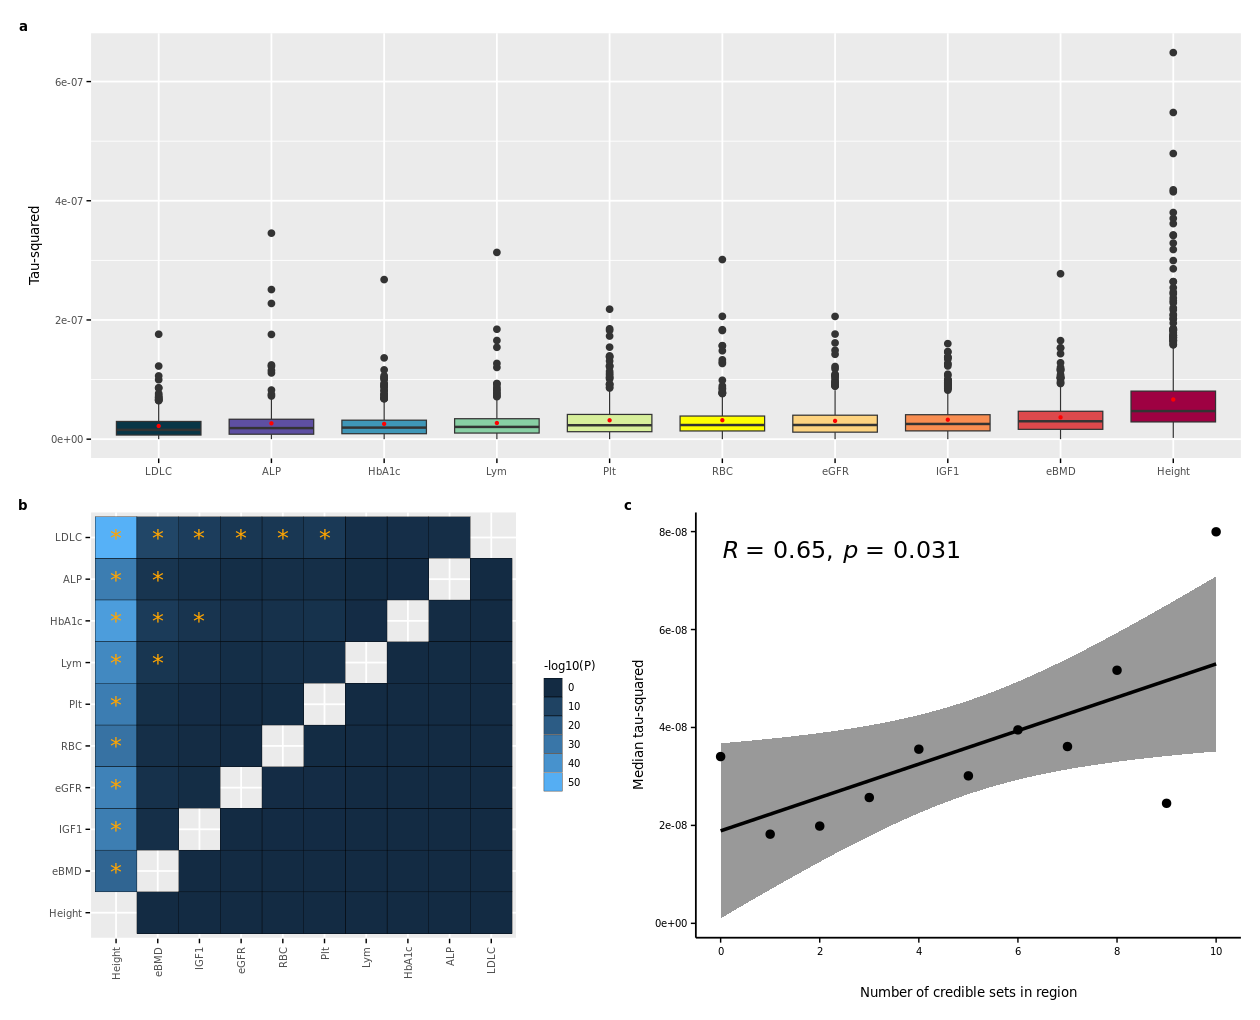

In [78]:
options(repr.plot.width=10.5, repr.plot.height=8.5)
layout <- "
AA
BC
"
ext_fig5 <- pl_trait_tausq + pl_heatmap + pl_cs_tausq +
 plot_layout(design=layout)+
 plot_annotation(tag_levels = "a") & theme(plot.tag = element_text(face = 'bold', size=8))

ext_fig5

In [20]:
cowplot::save_plot(
  paste0(path_pref, "/ExtFig5_tausq_in_real_data.jpg"),
  ext_fig5,
  base_height = 130,
  base_width = 180,
  device = jpeg,
  units = 'mm',
  dpi=600
)

# Extended Data Fig. 6 -- Agreement between SuSiE (inf) and FINEMAP (inf)

In [80]:
# feather files are available through the Zenodo link in the manuscript
sf_pips = read_feather(paste0(path_pref,'ukbb_susie_finemap_pip01.feather'))
sfinf_pips = read_feather(paste0(path_pref,'ukbb_susieinf_finemapinf_pip01.feather'))
num_highpip = read_excel("Supplementary Tables.xlsx", sheet = 27)
num_highpip$alt_name = c('SuSiE','FINEMAP','minPIP', 'meanPIP', 
                         'SuSiE','FINEMAP','minPIP', 'meanPIP')
num_highpip$alt_name = factor(num_highpip$alt_name, levels=c('SuSiE','FINEMAP','minPIP', 'meanPIP'))
sf_cor = cor(sf_pips$prob_susie, sf_pips$prob_finemap)
sfinf_cor = cor(sfinf_pips$prob_susieinf, sfinf_pips$prob_finemapinf)
pl_sf <- ggplot(sf_pips, aes(x=prob_susie, y=prob_finemap) ) +
  geom_bin2d(bins = 50) + xlab('SuSiE PIP') + ylab('FINEMAP PIP') + 
  ggtitle(sprintf('Correlation %.2f', sf_cor)) +
  scale_fill_continuous(type = "viridis") + pl_theme + theme(legend.title=element_blank())
pl_sfinf <- ggplot(sfinf_pips, aes(x=prob_susieinf, y=prob_finemapinf)) + 
  geom_bin2d(bins=50) + xlab('SuSiE-inf PIP') + ylab('FINEMAP-inf PIP') +
  ggtitle(sprintf('Correlation %.2f', sfinf_cor)) +
  scale_fill_continuous(type="viridis") + pl_theme + theme(legend.title=element_blank())
pl_num_highpip <- ggplot(num_highpip, aes(fill=type, y=num_highpip, x=alt_name)) + 
    ylab('Number of high-PIP variants') +
    geom_bar(position="dodge", stat="identity") + pl_theme + theme(axis.title.x = element_blank(),
                                                                   legend.title=element_blank())

New names:
• `` -> `...1`


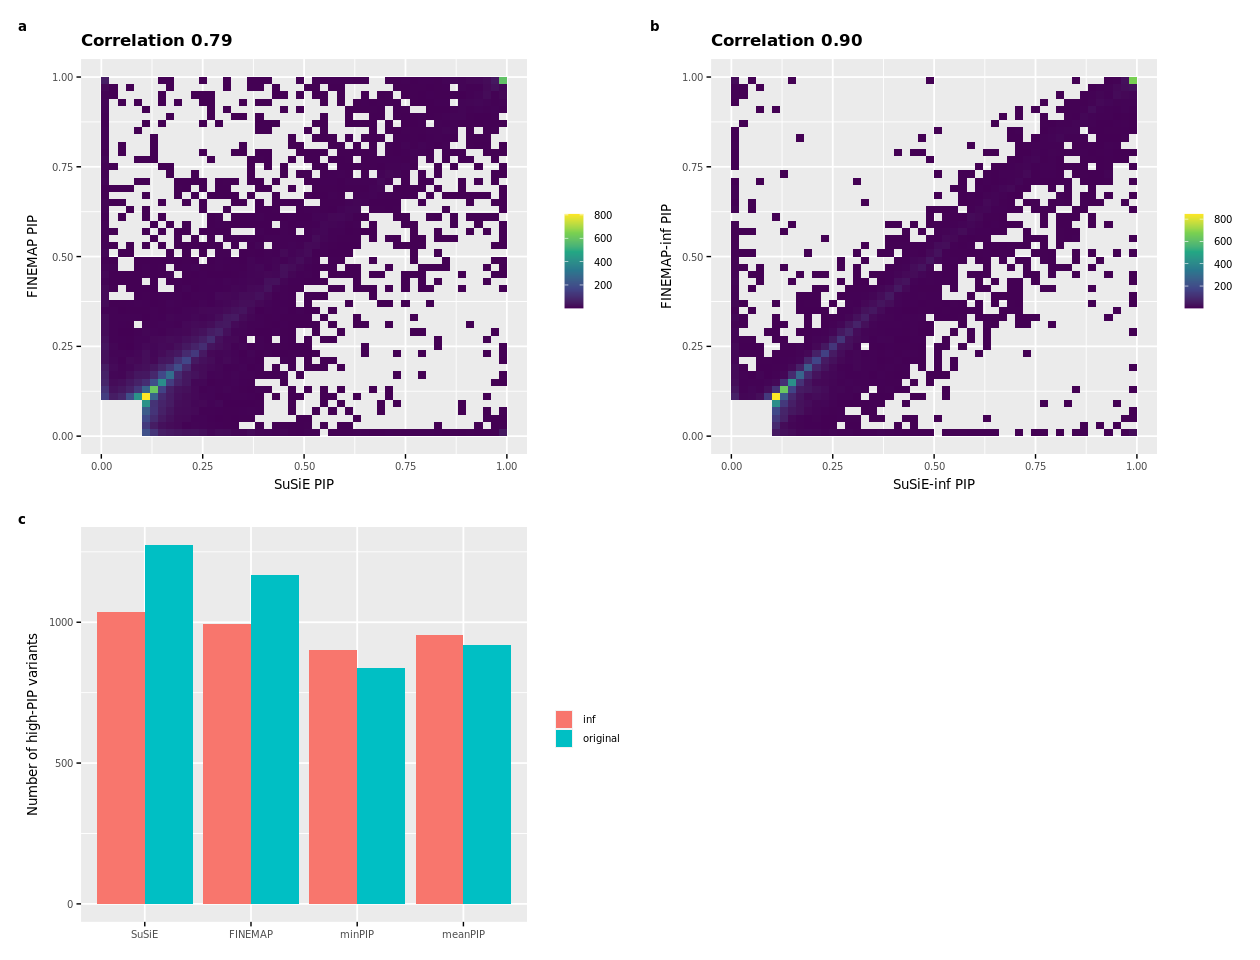

In [81]:
options(repr.plot.width=10.5, repr.plot.height=8)
layout <- "
AB
C#
"
ext_fig6 <- pl_sf + pl_sfinf + pl_num_highpip + plot_layout(design = layout)+
 plot_annotation(tag_levels = "a") & theme(plot.tag = element_text(face = 'bold', size=8))

ext_fig6

In [24]:
cowplot::save_plot(
  paste0(path_pref, "/ExtFig6_methods_agreement.jpg"),
  ext_fig6,
  base_height = 120,
  base_width = 180,
  device = jpeg,
  units = 'mm',
  dpi=600
)

# Extended Data Fig. 7 -- minPIP-inf performance

In [82]:
# RFR plots
# Aggregated RFR plot
rfr_df = read_excel("Supplementary Tables.xlsx", sheet = 4)
all_rfr = rfr_df %>% dplyr::select('trait','method_name','n_highpip','rfr','epn','data.type') 
all_rfr$segment_legend='EPN'
# Compute Binomial proportion SD
all_rfr$std = sqrt((all_rfr$rfr)*(all_rfr$n_highpip)*(1-all_rfr$rfr))/all_rfr$n_highpip
# Filter to aggregated RFR
selected_method_names = c('SuSiE','FINEMAP','SuSiE-inf','FINEMAP-inf','minPIP','minPIP-inf')
all_rfr = all_rfr %>% mutate(data.type = recode(data.type, 'Simulation' = 'Ideal simulation'))
data_to_plot = all_rfr %>% filter(trait=='agg') %>% filter(method_name %in% selected_method_names)
data_to_plot$method_name <- factor(data_to_plot$method_name, levels = selected_method_names)
data_to_plot$data.type <- factor(data_to_plot$data.type, levels=c('Real data','Ideal simulation'))
# Compute EPN line segment positions
num_methods = length(selected_method_names)
barwidth = 0.85/num_methods
pos_dodge = 1
xstart = c(seq(1-barwidth*num_methods/2,1+barwidth*num_methods/2-barwidth,length.out=num_methods),
  seq(1-barwidth*num_methods/2+pos_dodge, 1+barwidth*num_methods/2-barwidth+pos_dodge, length.out=num_methods))
xend = c(seq(1-barwidth*num_methods/2+barwidth,1+barwidth*num_methods/2,length.out=num_methods),
  seq(1-barwidth*num_methods/2+barwidth+pos_dodge,1+barwidth*num_methods/2+pos_dodge,length.out=num_methods))
# Plot
pl_rfr = ggplot(data=data_to_plot, aes(x=data.type, y=rfr, fill=method_name)) +
    geom_bar(position=position_dodge(), color='black', stat="identity",width=0.85, size=0.35) + 
    geom_segment(data=data_to_plot, aes(x=xstart, y=epn, 
                 xend=xend, yend=epn, 
                 color=method_name,linetype=`segment_legend`), 
                 size=0.4,color='black',inherit.aes = FALSE)+
    geom_errorbar(aes(ymin=rfr-std, ymax=rfr+std),position=position_dodge(.85),width=0.2,linewidth=0.2)+
    ylab(label = "Replication failure rate")+
    scale_linetype_manual("EPN",values=c("EPN"=1))+
    scale_fill_manual(values=method_colors[selected_method_names])+
    pl_theme + theme(axis.title.x = element_blank(),
                     legend.title = element_blank())

New names:
• `` -> `...1`


In [83]:
# Top N SNPs enrichment plot
top_n = read_excel("Supplementary Tables.xlsx", sheet = 16)
selected_methods = c('SuSiE-inf','FINEMAP-inf','minPIP-inf') 
top_n = (top_n %>% filter(method_name %in% selected_methods) %>% mutate(coding=(LoF + missense))
                            %>% mutate('putative regulatory'=(synonymous+UTR3+UTR5+promoter+CRE+conserved))
                            %>% dplyr::select(top_N, method_name, coding, 'putative regulatory', 'non-genic'))
melted_data <-  reshape2::melt(top_n , id.vars = c("top_N","method_name"), measure.vars = simple_annot_names)
data <- melted_data %>% group_by(top_N,method_name)
data <- mutate(data, prop = value / sum(value), 
               std = sqrt(sum(value)*(value/sum(value))*(1-(value/sum(value))))/sum(value),
               sd_pos = cumsum(prop))
data$method_name<-factor(data$method_name, levels= selected_methods)
data$variable <- factor(data$variable,levels=simple_annot_names)
pl_top_n <- qplot(x = method_name, y = prop, fill = variable, data = data, geom = "col") +
geom_errorbar(aes(x=method_name,ymin=1-prop+std,ymax=1-prop-std),width=.1, linewidth=0.3,
              data=data %>% filter(variable=='non-genic'),
              inherit.aes = FALSE)+
facet_wrap(~top_N)+
ggtitle('Top N variants')+
scale_fill_manual(values = simple_annot_colors) +
scale_y_continuous(label=c(0,0.25,0.5,0.75,1)) +
pl_theme + coord_flip() + theme(axis.title=element_blank(),
                                legend.title=element_blank())

New names:
• `` -> `...1`


In [84]:
# PRS plots
point_size = 3
prs_df = read_excel("Supplementary Tables.xlsx", sheet = 11)
p1_to_plot <- prs_df %>% filter(method_name %in% c('SuSiE-inf','minPIP-inf')) %>%
    reshape2::dcast(trait+cohort ~ method_name, value.var = "delta_r2") %>%
    na.omit()
p1 = ggplot(p1_to_plot,
       aes(x=`SuSiE-inf`,y=`minPIP-inf`, color=trait, shape=cohort)) +
    geom_point(size=point_size)+
    geom_abline(slope=1)+
    xlim(-0.001,NA)+ylim(-0.001,NA) +
    xlab('SuSiE-inf delta R2')+ylab('minPIP-inf delta R2')+
    scale_color_manual(values=pheno_colors[unique(p1_to_plot$trait)])+
    pl_theme + theme(legend.position = 'none')
# FINEMAP and FINEMAPinf
p2_to_plot <- prs_df %>% filter(method_name %in% c('FINEMAP-inf','minPIP-inf')) %>%
    reshape2::dcast(trait+cohort ~ method_name, value.var = "delta_r2") %>%
    na.omit()
p2 = ggplot(p2_to_plot,
       aes(x=`FINEMAP-inf`,y=`minPIP-inf`, color=trait,shape=cohort)) +
    geom_point(size=point_size, stroke=0.25)+
    geom_abline(slope=1, linewidth=0.25)+
    xlim(-0.001,NA)+ylim(-0.001,NA) +
    xlab('FINEMAP-inf delta R2')+ylab('minPIP-inf delta R2')+
    scale_color_manual(values=pheno_colors[unique(p1_to_plot$trait)])+
    pl_theme

pl_prs = p1 + p2  + plot_layout(ncol = 2, guides = "collect") +
plot_annotation(
  title = "PRS delta R2 comparisons",
  theme = theme(plot.title = element_text(size = 20,face='bold',hjust=0.4))
)

New names:
• `` -> `...1`


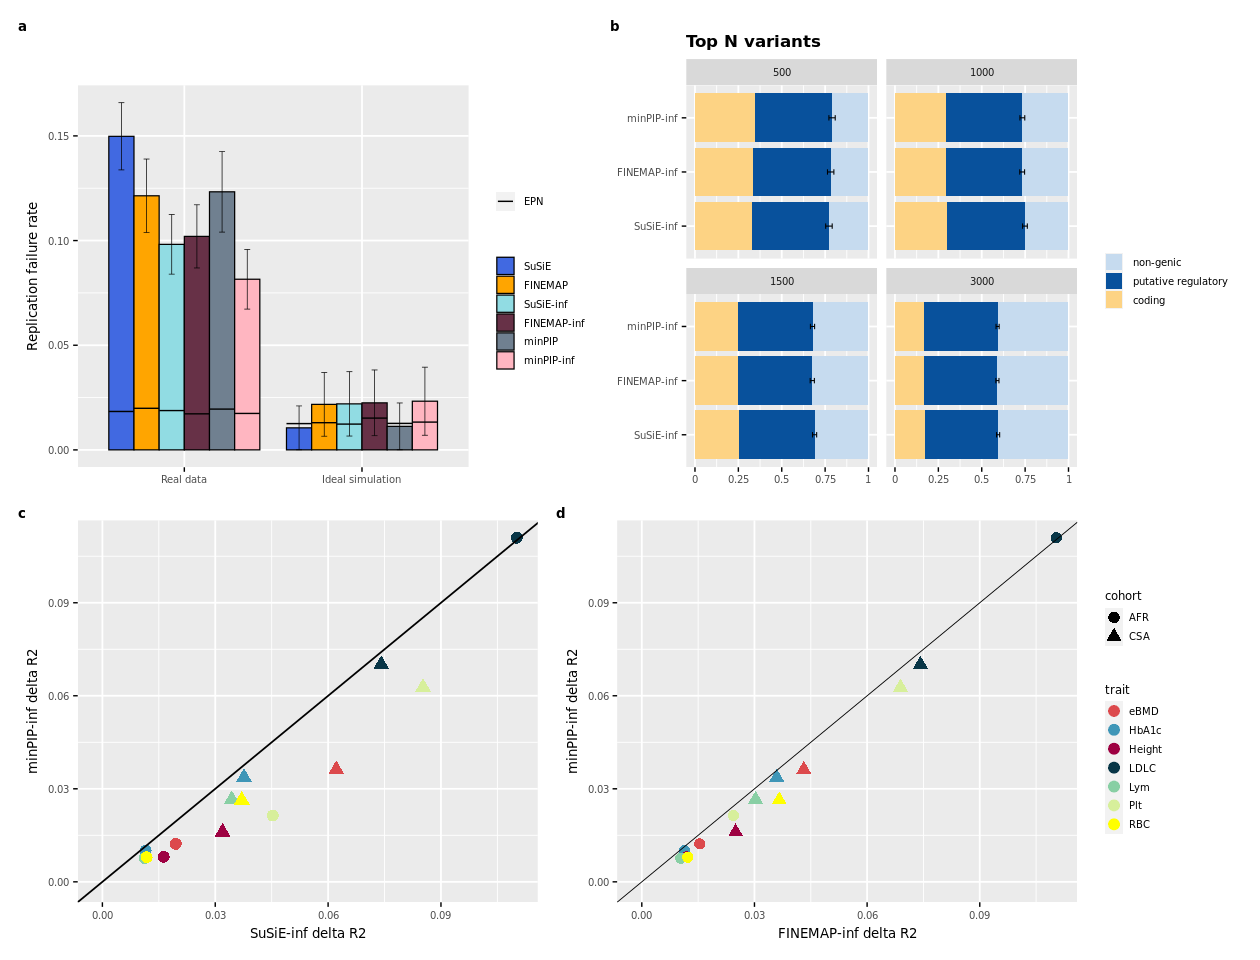

In [85]:
options(repr.plot.width=10.5, repr.plot.height=8)
layout <- "
AB
CC
"
ext_fig7 <- pl_rfr + pl_top_n +pl_prs + plot_layout(design = layout)+
 plot_annotation(tag_levels = "a") & theme(plot.tag = element_text(face = 'bold', size=8),
                                           legend.justification='left')

ext_fig7

In [62]:
cowplot::save_plot(
  paste0(path_pref, "/ExtFig7_minPIP_inf_performance.jpg"),
  ext_fig7,
  base_height = 120,
  base_width = 180,
  device = jpeg,
  units = 'mm',
  dpi=600
)

# Extended Data Fig. 10 -- PRS with error bars

In [104]:
plot_df = read_excel('Supplementary Tables.xlsx', sheet=12)
colnames(plot_df) = make.names(colnames(plot_df))

p1 = ggplot(plot_df,
       aes(x=SuSiE.Delta.R2,y=SuSiE.inf.Delta.R2, color=trait, shape=cohort)) +
    geom_point(size=point_size, stroke=0.25)+
    geom_errorbar(aes(ymin=SuSiE.inf.Delta.R2-SuSiE.inf.Delta.R2.SE, 
                      ymax=SuSiE.inf.Delta.R2+SuSiE.inf.Delta.R2.SE), 
                  width=.3, linewidth=0.3) +
    geom_errorbar(aes(xmin=SuSiE.Delta.R2-SuSiE.Delta.R2.SE, 
                      xmax=SuSiE.Delta.R2+SuSiE.Delta.R2.SE), 
                  width=.3, linewidth=0.3) +
    geom_abline(slope=1, linewidth=0.25)+
    xlim(-0.02,0.09)+ylim(-0.001,0.16)+
    xlab('SuSiE')+ylab('SuSiE-inf')+scale_color_brewer(palette='Set1')+
    pl_theme

p2 = ggplot(plot_df,
       aes(x=FINEMAP.Delta.R2,y=FINEMAP.inf.Delta.R2, color=trait,shape=cohort)) +
    geom_point(size=point_size, stroke=0.25)+
    geom_errorbar(aes(ymin=FINEMAP.inf.Delta.R2-FINEMAP.inf.Delta.R2.SE, 
                      ymax=FINEMAP.inf.Delta.R2+FINEMAP.inf.Delta.R2.SE), width=.3, linewidth=0.3) +
    geom_errorbar(aes(xmin=FINEMAP.Delta.R2-FINEMAP.Delta.R2.SE, 
                      xmax=FINEMAP.Delta.R2+FINEMAP.Delta.R2.SE), 
                  width=.3, linewidth=0.3) +
    geom_abline(slope=1, linewidth=0.25)+
    xlim(-0.02,0.09)+ylim(-0.001,0.16)+
    xlab('FINEMAP')+ylab('FINEMAP-inf')+scale_color_brewer(palette='Set1')+
    pl_theme

New names:
• `` -> `...1`


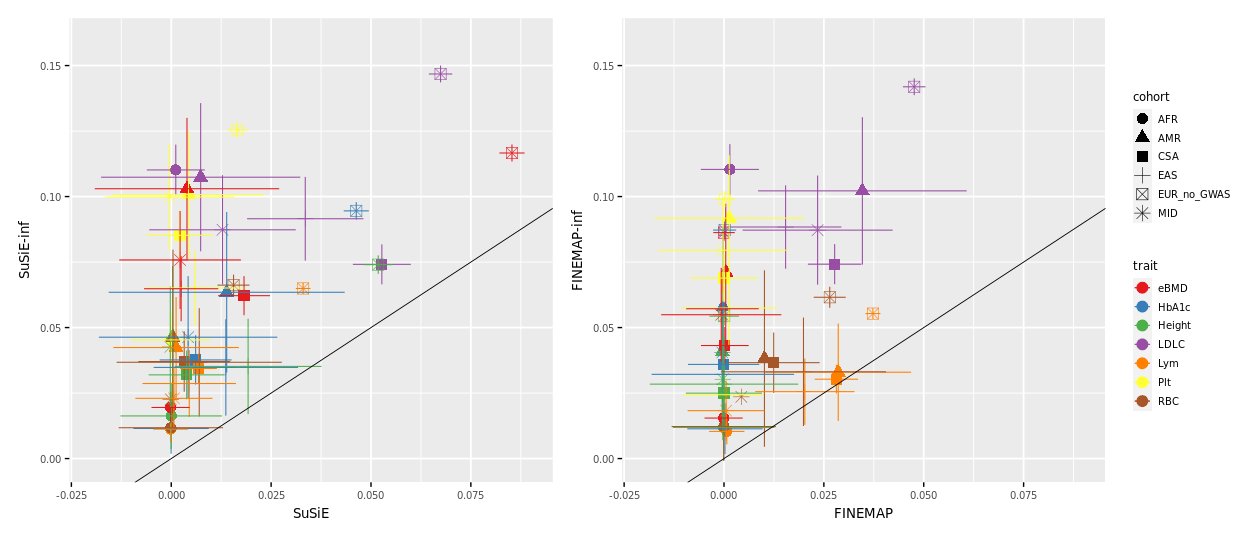

In [105]:
options(repr.plot.width=10.5, repr.plot.height=4.5)
ext_fig10 <- p1 + p2  + plot_layout(ncol = 2, guides = "collect")
ext_fig10

In [75]:
cowplot::save_plot(
  paste0(path_pref,"/ExtFig10_prs_with_error_bars.jpg"),
  ext_fig10,
  base_height = 80,
  base_width = 180,
  device = jpeg,
  units = 'mm',
  dpi=600
)